# Crosstalk ploting
1. time evolution of expectation of $ \sigma_z(t)$ 

Running QuTiP simulation (nanosecond scale)...
Simulation complete.
Saving animation to qubit_crosstalk_ns_scale.gif...
GIF saved successfully.


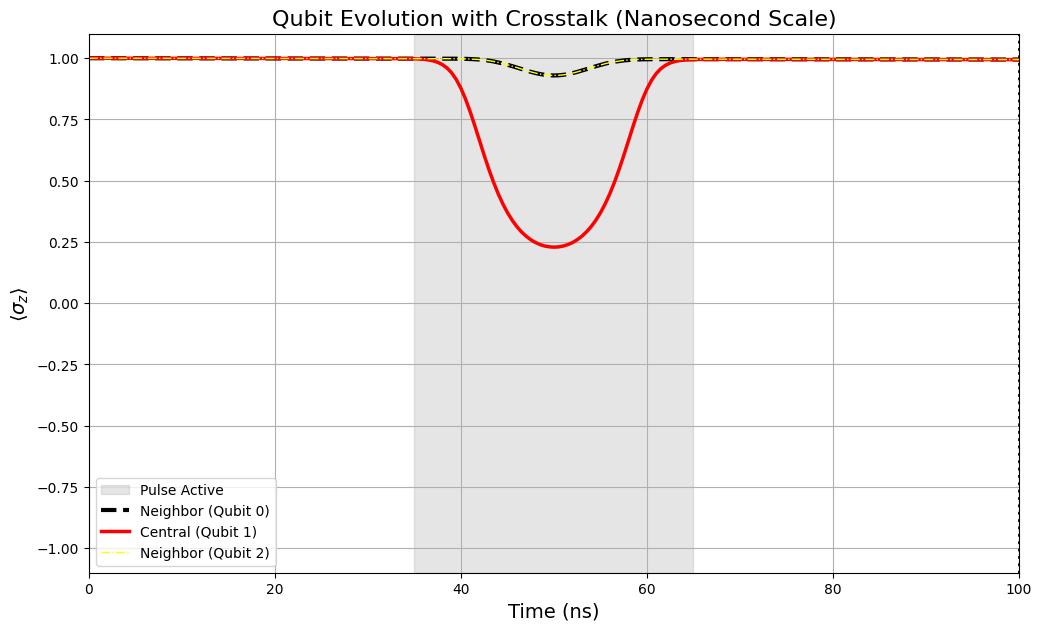

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- 1. SETUP THE SIMULATION (NANOSECOND SCALE) ---

# System parameters
N = 3
qubit_c = 1
w_q = 5.0 * 2 * np.pi        # Qubit frequency in rad/ns (i.e., 5 GHz)
Omega_c = 10.0 * 2 * np.pi   # Rabi frequency in rad/ns (i.e., 10 GHz)
J_coupling = 0.1 * Omega_c   # Induced coupling strength

# Pulse parameters (in nanoseconds)
t_total = 100.0
t0 = 50.0
tau = 5.0

def pulse_shape(t, args):
    """Gaussian pulse envelope."""
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

# Decoherence parameters (in nanoseconds)
T1 = 50000.0  # 50 us
T2_star = 10000.0  # 10 us
gamma1 = 1.0 / T1
gamma2_star = 1.0 / T2_star

# --- 2. CONSTRUCT HAMILTONIAN AND OPERATORS (Unchanged logic) ---

# Pauli operators for each qubit
sx = [qt.tensor([qt.qeye(2)]*i + [qt.sigmax()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
sz = [qt.tensor([qt.qeye(2)]*i + [qt.sigmaz()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
sm = [qt.tensor([qt.qeye(2)]*i + [qt.sigmam()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]

# Drift Hamiltonian
H_drift = -0.5 * w_q * sz[0] - 0.5 * w_q * sz[1] - 0.5 * w_q * sz[2]

# Control and Crosstalk Hamiltonian operators
H_control_op = Omega_c * sx[qubit_c]
H_crosstalk_op = J_coupling * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])
H = [H_drift, [H_control_op + H_crosstalk_op, pulse_shape]]

# Collapse operators
c_ops = []
for i in range(N):
    c_ops.append(np.sqrt(gamma1) * sm[i])
    c_ops.append(np.sqrt(gamma2_star) * sz[i])

# --- 3. RUN THE SIMULATION ---

psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0), qt.basis(2,0))
tlist = np.linspace(0, t_total, 201)
args = {'t0': t0, 'tau': tau}

print("Running QuTiP simulation (nanosecond scale)...")
result = qt.mesolve(H, psi0, tlist, c_ops, e_ops=[sz[0], sz[1], sz[2]], args=args)
print("Simulation complete.")

# --- 4. CREATE THE GIF (Unchanged logic) ---

times = result.times
exp_sz0 = result.expect[0]
exp_sz1 = result.expect[1]
exp_sz2 = result.expect[2]

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlim(0, t_total)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('Time (ns)', fontsize=14) # Changed label to ns
ax.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=14)
ax.set_title('Qubit Evolution with Crosstalk (Nanosecond Scale)', fontsize=16)
ax.grid(True)

pulse_vals = [pulse_shape(t, args) for t in times]
ax.fill_between(times, -1.1, 1.1, where=np.array(pulse_vals) > 0.01, color='gray', alpha=0.2, label='Pulse Active')

line0, = ax.plot([], [], lw=3, color='black', linestyle='--', label='Neighbor (Qubit 0)')
line1, = ax.plot([], [], lw=2.5, color='red', label='Central (Qubit 1)')
line2, = ax.plot([], [], lw=1, color='yellow', linestyle='-.', label='Neighbor (Qubit 2)')
time_marker = ax.axvline(0, color='black', lw=2, linestyle=':')
ax.legend(loc='lower left')

def init():
    line0.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    time_marker.set_xdata([0])
    return line0, line1, line2, time_marker

def update(frame):
    line0.set_data(times[:frame+1], exp_sz0[:frame+1])
    line1.set_data(times[:frame+1], exp_sz1[:frame+1])
    line2.set_data(times[:frame+1], exp_sz2[:frame+1])
    time_marker.set_xdata([times[frame]])
    return line0, line1, line2, time_marker

ani = FuncAnimation(fig, update, frames=len(times), init_func=init, blit=True)
gif_filename = 'qubit_crosstalk_ns_scale.gif'
print(f"Saving animation to {gif_filename}...")
ani.save(gif_filename, writer='pillow', fps=25)
print("GIF saved successfully.")
plt.show()


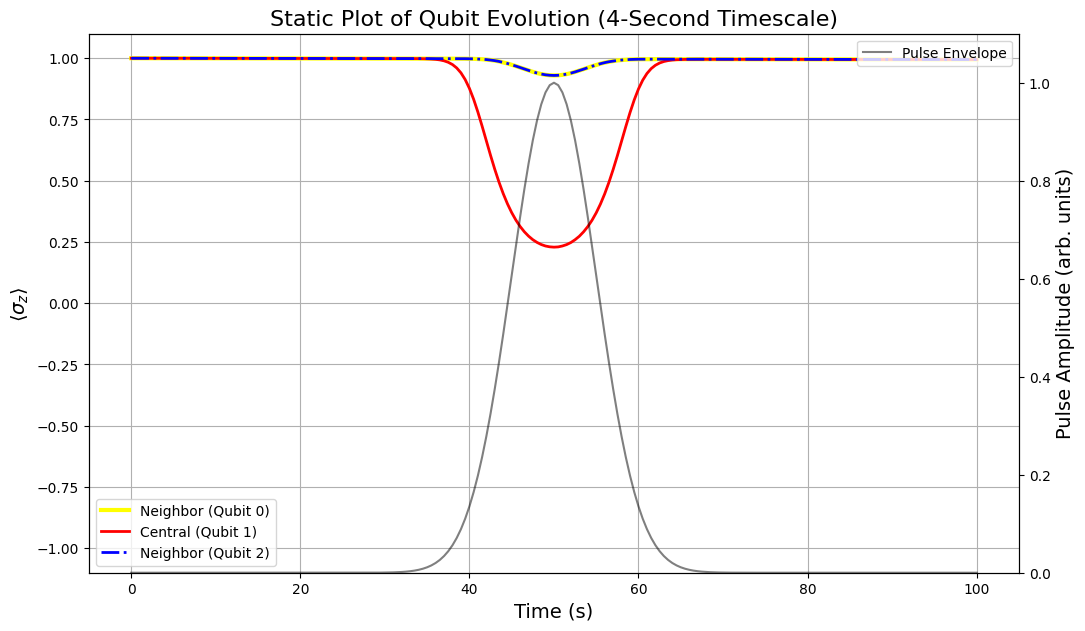

In [2]:
# CELL 2: Generate the Static Plot
# This cell assumes the simulation from the "GIF script" has been run in a previous cell.
# It uses the existing 'result', 'times', and 'args' variables from memory.



# --- 1. COMPUTE PULSE VALUES FOR PLOTTING ---
# We use the 'pulse_shape' function and 'args' dictionary defined in the previous cell.
pulse_vals = [pulse_shape(t, args) for t in times]

# --- 2. CREATE THE STATIC PLOT ---
# This uses the plotting style you provided.

# Setup the figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot the expectation values on the primary axis (ax1)
# Using the styling from your example
ax1.plot(times, exp_sz0, label='Neighbor (Qubit 0)', color='yellow', linestyle='-', linewidth=3)
ax1.plot(times, exp_sz1, label='Central (Qubit 1)', color='red', linestyle='-', linewidth=2)
ax1.plot(times, exp_sz2, label='Neighbor (Qubit 2)', color='blue', linestyle='-.', linewidth=2)

# Set labels, title, and grid for the primary axis
# IMPORTANT: The xlabel is 'Time (s)' to match the physics of the simulation.
ax1.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=14)
ax1.set_title('Static Plot of Qubit Evolution (4-Second Timescale)', fontsize=16)
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_ylim(-1.1, 1.1)

# --- 3. OVERLAY THE PULSE SHAPE ---

# Create a secondary axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the pulse envelope on the secondary axis (ax2)
ax2.plot(times, pulse_vals, label='Pulse Envelope', color='black', alpha=0.5)
ax2.set_ylabel('Pulse Amplitude (arb. units)', fontsize=14)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.1) # Keep the pulse axis clean from 0 to 1

# Display the final plot
plt.show()
